In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import torch.nn as nn
import os
import re
import torch
import random
import time
import math

In [2]:
SOS_token = 0
EOS_token = 1
rare_token = 2
period_token = 3
ellipsis_token = 4

class Lang:
    def __init__(self):
        #self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS", rare_token:'RARE_WORD', period_token: '.', ellipsis_token: '...'}
        self.word2index = {v: k for k, v in self.index2word.items()}
        self.n_words = len(self.index2word)  # Count SOS and EOS and RARE_WORD

    def addLine(self, line):
        # This crazy thing splits the phrase by ' ', ';', ',', and splits while keeping by '...' and '.'
        # tokenize splits into words and stuff, not into indices
        for word in tokenize(line):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2count:
            #self.word2index[word] = self.n_words
            self.word2count[word] = 1
            #self.index2word[self.n_words] = word
            #self.n_words += 1
        else:
            self.word2count[word] += 1

    def prune(self):
        old_word2count = self.word2count.copy()
        for word, counts in old_word2count.items():
            if counts < 20:
                self.word2count.pop(word)
                #index = self.word2index[word]
                #self.word2index.pop(word)
                #self.index2word.pop(index)
        for word in self.word2count.keys():
            if word in self.word2index.keys():
                # This means it's one of the pre-set ones we did in __init__
                # shouldn't need to do anything else?
                continue
                
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1
        #self.n_words = len(self.word2count.keys())
        

data is from http://www.st-minutiae.com/academy/literature329/#deepspacenine

In [3]:
def split_string_into_sentences(in_string):
    out_list = []
    last = ''
    for i in re.split(r'(?<!\.)(\.)(?!\.)',in_string.lower()):
        if i == '.':
            last += i
            out_list.append(last)
            last = ''
        else:
            if last:
                out_list.append(last)
            last = i
    if last:
        out_list.append(last)
    return out_list

In [4]:
len(os.listdir('../scripts_ds9'))

173

In [5]:
def tokenize(line):
    return [x for x in re.split(r' |; |, |(\.{3,})|(\.)|(\!)|(\?)|(\-{2})',line.lower()) if x]

def indexesFromLine(line):
    return [lang.word2index[word] if word in lang.word2index else rare_token for word in tokenize(line)]

# Don't do this... we need one-hot for the gradients? This only works with attention head stuff. 
# I'll figure that out later
def tensorFromLine(lang, line):
    indexes = indexesFromLine(lang, line)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

# Turn a line into a <line_length x 1 x n_words>,
# or an array of one-hot word vectors
def lineToTensor(line):
    line_tokens = [lang.word2index[word] if word in lang.word2index else rare_token for word in tokenize(line)]
    line_tokens.append(EOS_token)
    #print(line_tokens)
    tensor = torch.zeros(len(line_tokens), 1, lang.n_words)
    for i, token in enumerate(line_tokens):
        tensor[i][0][token] = 1
    return tensor

def lineToIndexTensor(line):
    line_tokens = indexesFromLine(line)
    line_tokens.append(EOS_token)
    #print(line_tokens)
    out_tensor = torch.tensor(line_tokens, dtype=torch.long)
    return out_tensor

In [15]:
scenes = {}
char_line_num = -1
blank_line_num = -1
dialogues = []
dialogue = ''

dialogue_in_sentences = False

could_be_dialogue = False
for script_file in os.listdir('../scripts_ds9'):
    print(f'parsing: ../scripts_ds9/{script_file}')
    with open('../scripts_ds9/' + script_file, encoding = 'latin-1') as f:
        for i, line in enumerate(f):
            #print(line)
            if line != '\n':
                series_title = line.strip()
                break
    
        for i, line in enumerate(f):
            #print(line)
            if '"' in line:
                episode_title = line.strip().replace('"','')
                break
    
        scene_num = 0
        for i, line in enumerate(f):
            # check if it's a new scene
            if line[0].isdigit():
                scene_num = line.split()[0]
                # check if it's actually a number '5' or something like '5A'
                if scene_num.isnumeric():
                    #print(scene_num)
                    scenes[scene_num] = ' '.join(line.split()[1::])
    
            if scene_num == 0:
                continue
            #else:
                #print(line)
            
            # Method 2 based on tabs
            if line.strip() == '':
                if dialogue:
                    if dialogue_in_sentences:
                        for sentence in split_string_into_sentences(dialogue):
                            word_list = tokenize(sentence)
                            dialogues.append({'char_name': char_name,
                                              'dialogue': sentence,
                                              'episode': episode_title,
                                              'word_list': word_list,
                                              'n_tokens': len(word_list)
                                             })
                                              #'index_tensor': lineToIndexTensor(sentence)})
                    else:
                        dialogues.append({'char_name': char_name, 'dialogue': dialogue, 'episode':episode_title})
                could_be_dialogue = False
                dialogue = ''
                blank_line_num = i

            if line.isupper() and i == blank_line_num + 1:
                char_line_num = i
                char_name = line.strip()\
                .removesuffix('(V.O.)')\
                .removesuffix('(O.S.)')\
                .removesuffix("'S VOICE")\
                .removesuffix("'S COM VOICE")\
                .strip()
                could_be_dialogue = True

            if line.count('\t') == 3:
                #print(line)
                if dialogue:
                    dialogue += ' '
                dialogue += line.strip()

dialogue_df = pd.DataFrame(dialogues)

if not dialogue_in_sentences:
    dialogue_df['word_list'] = dialogue_df.dialogue.apply(tokenize)
    dialogue_df['n_tokens'] = dialogue_df['word_list'].apply(len)

display(dialogue_df)

parsing: ../scripts_ds9/504.txt
parsing: ../scripts_ds9/510.txt
parsing: ../scripts_ds9/538.txt
parsing: ../scripts_ds9/470.txt
parsing: ../scripts_ds9/464.txt
parsing: ../scripts_ds9/458.txt
parsing: ../scripts_ds9/459.txt
parsing: ../scripts_ds9/465.txt
parsing: ../scripts_ds9/471.txt
parsing: ../scripts_ds9/539.txt
parsing: ../scripts_ds9/511.txt
parsing: ../scripts_ds9/505.txt
parsing: ../scripts_ds9/513.txt
parsing: ../scripts_ds9/507.txt
parsing: ../scripts_ds9/498.txt
parsing: ../scripts_ds9/467.txt
parsing: ../scripts_ds9/472.txt
parsing: ../scripts_ds9/466.txt
parsing: ../scripts_ds9/499.txt
parsing: ../scripts_ds9/506.txt
parsing: ../scripts_ds9/512.txt
parsing: ../scripts_ds9/516.txt
parsing: ../scripts_ds9/502.txt
parsing: ../scripts_ds9/489.txt
parsing: ../scripts_ds9/462.txt
parsing: ../scripts_ds9/476.txt
parsing: ../scripts_ds9/477.txt
parsing: ../scripts_ds9/463.txt
parsing: ../scripts_ds9/488.txt
parsing: ../scripts_ds9/503.txt
parsing: ../scripts_ds9/517.txt
parsing:

,char_name,dialogue,episode,word_list,n_tokens
0,O'BRIEN,They looked fine last night.,The Assignment,"[they, looked, fine, last, night, .]",6
1,BASHIR,They don't look so fine now.,The Assignment,"[they, don't, look, so, fine, now, .]",7
2,O'BRIEN,I can't understand it... I've been following K...,The Assignment,"[i, can't, understand, it, ..., i've, been, fo...",14
3,BASHIR,They were dry as a bone when I came by for you...,The Assignment,"[they, were, dry, as, a, bone, when, i, came, ...",25
4,O'BRIEN,You watered them?,The Assignment,"[you, watered, them, ?]",4
...,...,...,...,...,...
73023,SISKO,I take it this is our assassin?,The Darkness and the Light,"[i, take, it, this, is, our, assassin, ?]",8
73024,ODO,Why did he give you a sedative?,The Darkness and the Light,"[why, did, he, give, you, a, sedative, ?]",8
73025,49 CONTINUED:,He wanted to protect the innocent... and separ...,The Darkness and the Light,"[he, wanted, to, protect, the, innocent, ..., ...",42
73026,KIRA,Let's go home.,The Darkness and the Light,"[let's, go, home, .]",4


In [ ]:
with pd.option_context("display.max_rows", 10000):
    display(dialogue_df.char_name.value_counts())
    #display(dialogue_df.episode.value_counts())

In [ ]:
with pd.option_context("display.max_rows", 10000):
    display(dialogue_df.n_tokens.value_counts().sort_index())
    dialogue_df.n_tokens.value_counts().sort_index().plot()

In [18]:
# Fix some naming issues
dialogue_df.loc[dialogue_df['char_name'] == 'GUL DUKAT', 'char_name'] = 'DUKAT'
dialogue_df.loc[dialogue_df['char_name'] == 'JADZIA', 'char_name'] = 'DAX'

In [22]:
# Some quick checks to learn about the data
counts_series = dialogue_df.char_name.value_counts()
dialogue_trim_df = dialogue_df[dialogue_df['char_name'].isin(counts_series[counts_series >= 1000].index)]
dialogue_trim_df = dialogue_trim_df[dialogue_trim_df.n_tokens.isin(range(3,9))]
dialogue_trim_df.reset_index(drop=True, inplace = True)

In [24]:
dialogue_df.char_name.value_counts().iloc[0:14]

char_name
SISKO      9375
KIRA       5847
BASHIR     5495
O'BRIEN    5271
QUARK      5080
ODO        5055
DAX        4201
WORF       2200
JAKE       1614
GARAK      1601
DUKAT      1389
NOG        1317
ROM        1302
EZRI       1069
Name: count, dtype: int64

In [25]:
dialogue_trim_df.groupby('char_name').n_tokens.agg('mean')

char_name
BASHIR     12.683712
DAX        11.849322
DUKAT      15.774658
EZRI       11.242283
GARAK      16.005621
JAKE       10.173482
KIRA       11.912434
NOG        10.861807
O'BRIEN    11.973060
ODO        12.144807
QUARK      13.453937
ROM        11.241935
SISKO      12.515627
WORF       11.704545
Name: n_tokens, dtype: float64

In [26]:
def prep_datasets(input_df, min_tokens, max_tokens, min_char_lines = 1000):
    # The n_tokens range for the input is also something that might be worth tuning or ignoring
    counts_series = input_df.char_name.value_counts()
    dialogue_trim_df = input_df[input_df['char_name'].isin(counts_series[counts_series >= min_char_lines].index)]
    dialogue_trim_df = dialogue_trim_df[dialogue_trim_df.n_tokens.isin(range(min_tokens, max_tokens+1))]
    dialogue_trim_df.reset_index(drop=True, inplace = True)

    char_categories = dialogue_trim_df.char_name.drop_duplicates().to_list()

    # NOTE: random_state might need variability one day
    seed = 1
    test_df = dialogue_trim_df.sample(frac=0.2, random_state=seed, replace=False)
    train_df = dialogue_trim_df.drop(test_df.index)
    
    valid_df = test_df.sample(frac=0.2, random_state=seed+1, replace=False)
    test_df = test_df.drop(valid_df.index)
    
    lang = Lang()
    for line in dialogue_trim_df.dialogue.to_list():
        lang.addLine(line)
    lang.prune()

    return lang, train_df, valid_df, test_df, char_categories

In [27]:
# More quick checks to see how data is distributed
lang, train_df, valid_df, test_df, char_categories = prep_datasets(dialogue_df, min_tokens = 3, max_tokens = 8)

In [28]:
# NOTE: random_state might need variability one day
seed = 1
test_df = dialogue_trim_df.sample(frac=0.2, random_state=seed, replace=False)
train_df = dialogue_trim_df.drop(test_df.index)

valid_df = test_df.sample(frac=0.2, random_state=seed+1, replace=False)
test_df = test_df.drop(valid_df.index)

In [29]:
print(f'total size = {dialogue_trim_df.shape[0]}')
print(f'test size = {test_df.shape[0]}')
print(f'valid size = {valid_df.shape[0]}')
print(f'train size = {train_df.shape[0]}')

total size = 50816
test size = 8130
valid size = 2033
train size = 40653


In [30]:
# do we need this cell anymore?
lang = Lang()
for line in dialogue_trim_df.dialogue.to_list():
    lang.addLine(line)

print(len(lang.word2count))
lang.prune()
print(len(lang.word2count))

18236
2046


In [31]:
# Need to classify the output
char_categories = dialogue_trim_df.char_name.drop_duplicates().to_list()
n_categories = len(char_categories)
print(char_categories)
print(f'n_categories = {n_categories}')

["O'BRIEN", 'BASHIR', 'ROM', 'JAKE', 'SISKO', 'DAX', 'ODO', 'WORF', 'QUARK', 'KIRA', 'GARAK', 'NOG', 'DUKAT', 'EZRI']
n_categories = 14


In [32]:
# modified from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_dim):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.embed = nn.Embedding(input_size, embedding_dim)

        self.i2h = nn.Linear(embedding_dim + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        #print(input)
        #print(input.size())
        embedded = self.embed(input).unsqueeze(0)
        #print(embedded)
        #print(embed_tensor.size())
        combined = torch.cat((embedded, hidden),1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



In [34]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return char_categories[category_i], category_i

#print(categoryFromOutput(output))

In [35]:
def randomTrainingExample(df):
    category = random.choice(char_categories)
    line = df.loc[df.char_name == category].sample().dialogue.iloc[0]
    category_tensor = torch.tensor([char_categories.index(category)], dtype=torch.long)
    line_tensor = lineToIndexTensor(line)
    return category, line, category_tensor, line_tensor

# Some sample examples for fun
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample(train_df)
    print(f'category = {category} / line = {line}')

category = BASHIR/ line = You sound relieved.
category = EZRI/ line = I have three -- no, four lifetimes worth of memories about raising children.
category = NOG/ line = No, I meant you should call me "sir."
category = EZRI/ line = You go. I'm staying here.
category = QUARK/ line = You Cardassians do hold grudges. Seven years ago Natima and I had some silly lovers' quarrel and... Well, all I can say is... I'm willing to let bygones be bygones.
category = SISKO/ line = I can't let her die.  Not again.
category = ODO/ line = He's trying to land on that moon.
category = NOG/ line = If they're breeding Jem'Hadar in this quadrant, the Dominion won't have to worry about bringing any reinforcements through the wormhole.
category = O'BRIEN/ line = She works in a flower shop. Arranging flowers.
category = ROM/ line = I was following you.


In [49]:
# This trains using just one data point
def train(rnn, category_tensor, line_tensor, criterion, learning_rate = 0.005):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return rnn, output, loss.item()

In [50]:
# This trains the model using a dataset
def train_model(rnn, train_df, n_iters, criterion, learning_rate = 0.005, verbose = True):

    print_every = int(n_iters / 20)
    plot_every = int(n_iters / 100)

    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    confusion = torch.zeros(n_categories, n_categories)

    # score since last print
    n_correct = 0
    n_wrong = 0
    p=1./len(char_categories)

    if verbose:
        print(f'We expect, if random guesses, n_correct = {p*print_every:.3f} +/- {math.sqrt(print_every*p*(1-p)):.3f}')

    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    start = time.time()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample(train_df)
        rnn, output, loss = train(rnn, category_tensor, line_tensor, criterion, learning_rate)
        current_loss += loss
        guess, guess_i = categoryFromOutput(output)
        #category_i = char_categories.index(category)
        #confusion[category_i][guess_i] += 1
        if guess == category:
            n_correct += 1
        else:
            n_wrong += 1
    
        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = 'Y' if guess == category else 'N (%s)' % category
            print('%d %d%% (%s) %d %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), n_correct, line, guess, correct))
            n_correct = 0
            n_wrong = 0
        
        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

    return rnn, all_losses

In [51]:
def evaluate(test_df, n_trials):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 10000
    tot_loss = 0
    
    # Just return an output given a line
    def evaluate_line(line_tensor):
        hidden = rnn.initHidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
    
        return output
    
    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample(test_df)
        output = evaluate_line(line_tensor)
        tot_loss += criterion(output, category_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = char_categories.index(category)
        confusion[category_i][guess_i] += 1

    n_correct = 0
    for i in range(n_categories):
        n_correct += int(confusion[i][i])
        # Normalize by dividing every row by its sum
        #confusion_trained[i] = confusion_trained[i] / confusion_trained[i].sum()

    avg_loss = tot_loss / n_trials
    return confusion, n_correct, avg_loss

In [62]:
def plot_confusion(confusion, save_name = ''):
    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)
    
    # Set up axes
    ax.set_xticklabels([''] + char_categories, rotation=90)
    ax.set_yticklabels([''] + char_categories)
    
    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    ax.set_ylabel('correct answer')
    ax.set_xlabel('guess')

    if save_name != '':
        print(f'saving plot to: {save_name}')
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

    return fig, ax


validating with baseline
We expect, if random guesses, n_correct = 35.714 +/- 5.759
500 5% (0m 1s) 31 Something more? / QUARK N (EZRI)
1000 10% (0m 3s) 39 I was merely making an observation. / NOG N (EZRI)
1500 15% (0m 5s) 33 Twenty-one?  Ore processing? / KIRA N (ODO)
2000 20% (0m 7s) 37 I'm going to hold you to that. / JAKE N (EZRI)
2500 25% (0m 9s) 42 Computer. Where are Chu'lak's quarters? / ODO N (EZRI)
3000 30% (0m 11s) 43 He is a stubborn, arrogant man. / ROM N (WORF)
3500 35% (0m 13s) 38 Who knows, you might even enjoy yourself. / ODO N (KIRA)
4000 40% (0m 14s) 39 I don't even know anymore. / DUKAT N (KIRA)
4500 45% (0m 16s) 45 Torpedoes ready, sir. / WORF N (NOG)
5000 50% (0m 18s) 48 Why not?  Because I'm a Ferengi? / EZRI N (NOG)
5500 55% (0m 20s) 39 I can imagine... / EZRI N (KIRA)
6000 60% (0m 22s) 50 I eagerly await your decision. / WORF N (DUKAT)
6500 65% (0m 24s) 34 We're starting to roll. / DUKAT N (KIRA)
7000 70% (0m 25s) 42 This is a great day for us... / QUARK N (DU

/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + char_categories, rotation=90)
/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + char_categories)


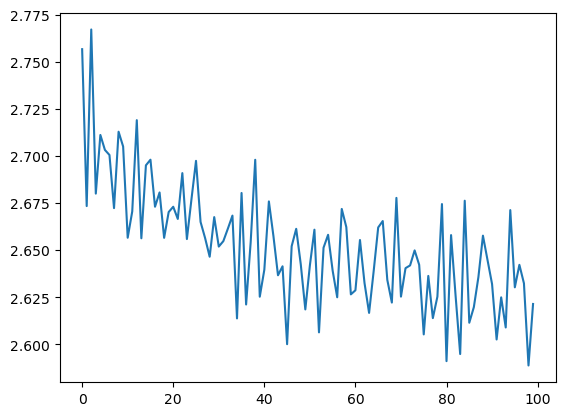

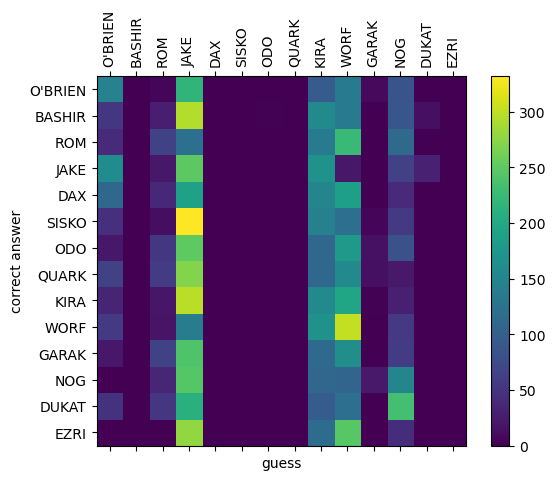


validating with few neurons
We expect, if random guesses, n_correct = 35.714 +/- 5.759
500 5% (0m 1s) 26 Can't talk now!  Gotta run! / O'BRIEN N (NOG)
1000 10% (0m 3s) 41 And... ? / BASHIR N (SISKO)
1500 15% (0m 5s) 36 The reception doesn't start for another -- / JAKE N (ODO)
2000 20% (0m 7s) 39 I'm proud of you, Dad. / EZRI N (JAKE)
2500 25% (0m 8s) 30 I'll take that chance. / SISKO N (QUARK)
3000 30% (0m 10s) 42 Pattern Delta? What's that? / BASHIR N (O'BRIEN)
3500 35% (0m 12s) 41 It's all a bunch of junk. / WORF N (NOG)
4000 40% (0m 13s) 42 Then Kang is coming? / EZRI N (DAX)
4500 45% (0m 15s) 57 Never better. / ODO N (SISKO)
5000 50% (0m 17s) 37 I'll have to remember that one. / NOG N (O'BRIEN)
5500 55% (0m 19s) 42 I said, don't touch me. / ROM N (GARAK)
6000 60% (0m 20s) 46 What makes you so sure? / JAKE Y
6500 65% (0m 22s) 39 You shouldn't just give up. / GARAK N (EZRI)
7000 70% (0m 24s) 54 Yes. Exactly. / BASHIR Y
7500 75% (0m 25s) 44 A friend of Curzon's. / WORF Y
8000 80% (0m

/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + char_categories, rotation=90)
/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + char_categories)


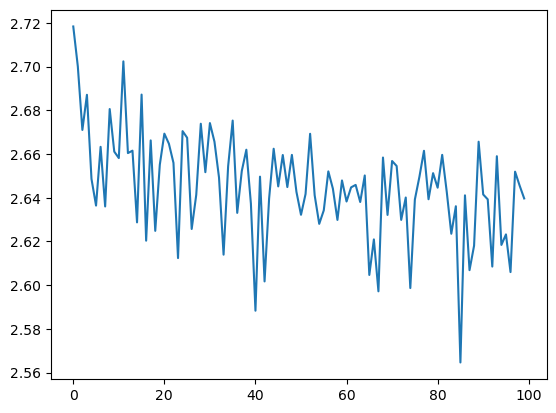

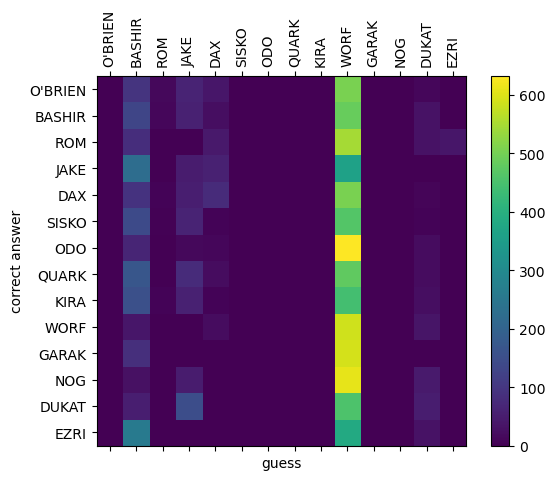


validating with faster learning
We expect, if random guesses, n_correct = 35.714 +/- 5.759
500 5% (0m 1s) 38 Did he really say "gung-gung- gung?" / KIRA N (WORF)
1000 10% (0m 3s) 29 A little over thirty years ago. / KIRA N (ODO)
1500 15% (0m 5s) 41 I was just starting to... / GARAK N (BASHIR)
2000 20% (0m 7s) 55 It's very... honorable. / EZRI Y
2500 25% (0m 9s) 38 Sounds like he was strict. / EZRI Y
3000 30% (0m 11s) 41 You should. He was your predecessor. / ODO N (GARAK)
3500 35% (0m 13s) 43 Where's your computer? / ODO N (NOG)
4000 40% (0m 15s) 49 They probably do already. / KIRA N (WORF)
4500 45% (0m 17s) 50 Is that when you took command? / QUARK N (NOG)
5000 50% (0m 19s) 55 I followed your instructions to the letter. / DUKAT N (QUARK)
5500 55% (0m 21s) 48 Is that a good idea? / EZRI Y
6000 60% (0m 23s) 45 Constable, I gave you a direct order. / O'BRIEN N (KIRA)
6500 65% (0m 25s) 48 Sisko to Doctor Bashir... / O'BRIEN N (SISKO)
7000 70% (0m 27s) 43 They could, but they won't. / ROM

/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + char_categories, rotation=90)
/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + char_categories)


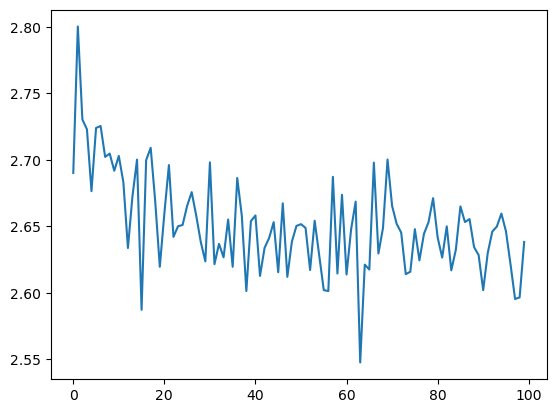

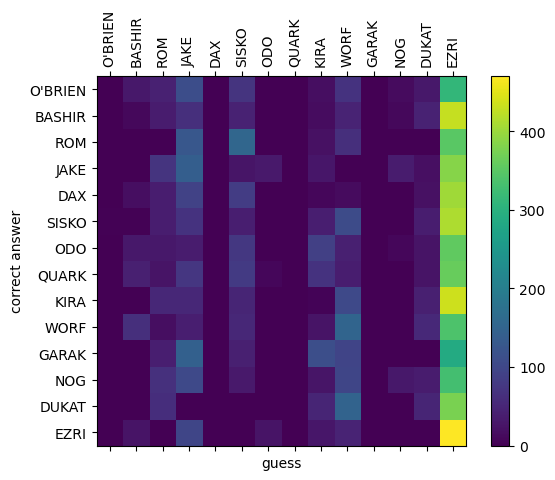


validating with different loss fnc
We expect, if random guesses, n_correct = 35.714 +/- 5.759
500 5% (0m 2s) 26 Go ahead. / WORF N (DUKAT)
1000 10% (0m 3s) 39 It's a big day. / GARAK N (EZRI)
1500 15% (0m 5s) 39 What kind of "alterations"? / GARAK N (DUKAT)
2000 20% (0m 7s) 56 I can't see from here. / KIRA N (O'BRIEN)
2500 25% (0m 10s) 38 Yes, Sir. / SISKO N (O'BRIEN)
3000 30% (0m 12s) 39 No more algae-paste. / KIRA N (EZRI)
3500 35% (0m 14s) 32 Nog?  Nog hasn't done anything wrong. / NOG N (ROM)
4000 40% (0m 16s) 55 That's all I ask. / ROM N (DAX)
4500 45% (0m 18s) 35 ... and your name is Ishan Chaye. / O'BRIEN N (GARAK)
5000 50% (0m 20s) 42 I'll live... / DAX N (KIRA)
5500 55% (0m 22s) 40 How's it feel now? / DAX N (BASHIR)
6000 60% (0m 24s) 35 I... don't believe we've been introduced. / DAX N (BASHIR)
6500 65% (0m 25s) 39 That's a relief. / WORF N (EZRI)
7000 70% (0m 27s) 46 Disruptor's effectiveness at fifty percent. / DUKAT N (WORF)
7500 75% (0m 29s) 46 Someone I care about might

/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + char_categories, rotation=90)
/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + char_categories)


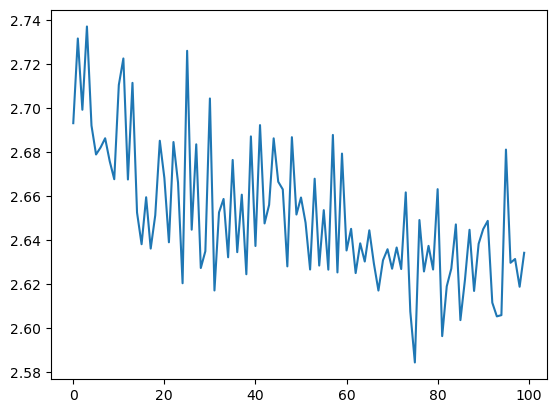

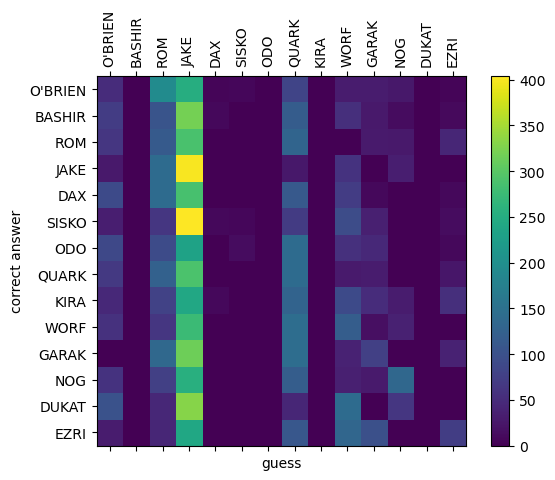


validating with more varied sentences
We expect, if random guesses, n_correct = 35.714 +/- 5.759
500 5% (0m 4s) 30 Exactly. So you'd better take our demands seriously. / WORF N (ROM)
1000 10% (0m 8s) 49 The conversations were just the beginning... I've also found records of gifts... of holidays spent at an Inn outside the capital... / ODO Y
1500 15% (0m 12s) 39 We'll go back to Cardassia, Ziyal. We'll be safe there. You'll live with me... father and daughter... everything will be fine. / NOG N (DUKAT)
2000 20% (0m 16s) 28 And what about now... are your eyes open... do you know what the risks are? / JAKE N (DAX)
2500 25% (0m 20s) 43 I hope I'm not intruding, but I couldn't help noticing... / KIRA N (GARAK)
3000 30% (0m 24s) 42 Don't worry, Garak, I'll help you through this... / DAX N (EZRI)
3500 35% (0m 29s) 39 We're married. / ODO N (ROM)
4000 40% (0m 33s) 54 It is the only way. You may begin. / WORF Y
4500 45% (0m 37s) 44 They're not? / NOG Y
5000 50% (0m 41s) 47 Someone's cut off ou

/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + char_categories, rotation=90)
/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + char_categories)


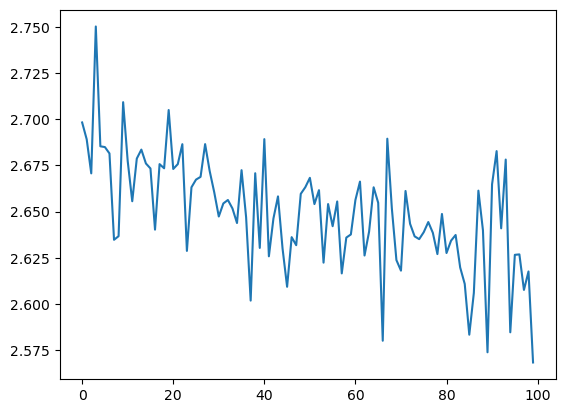

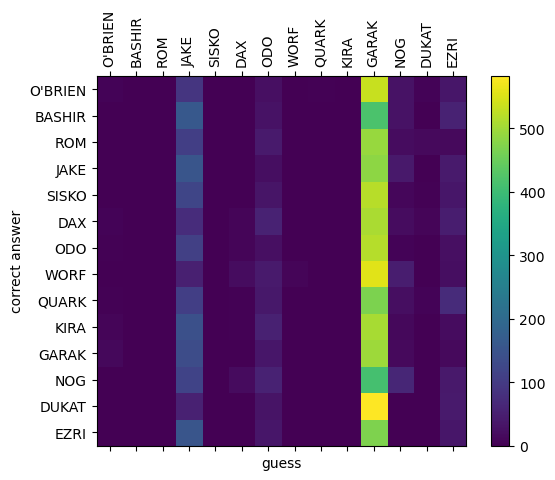


validating with fewer categories
We expect, if random guesses, n_correct = 83.333 +/- 8.333
500 5% (0m 1s) 90 A million going twice. / KIRA N (QUARK)
1000 10% (0m 3s) 77 Computer, end program. / KIRA N (O'BRIEN)
1500 15% (0m 5s) 79 How much longer? / O'BRIEN N (KIRA)
2000 20% (0m 7s) 77 Believe me, I'm not planning to. / QUARK Y
2500 25% (0m 8s) 84 How will that affect my visions? / KIRA N (SISKO)
3000 30% (0m 10s) 78 I understand... / ODO N (SISKO)
3500 35% (0m 12s) 88 Cut your engines. / SISKO N (O'BRIEN)
4000 40% (0m 13s) 83 I hope he knows what he's doing. / ODO N (O'BRIEN)
4500 45% (0m 15s) 88 Yes.  Like me. / O'BRIEN N (SISKO)
5000 50% (0m 17s) 90 So do I... / O'BRIEN N (QUARK)
5500 55% (0m 19s) 105 If that's what you want. / BASHIR N (O'BRIEN)
6000 60% (0m 21s) 95 But he's not a Founder. / SISKO N (KIRA)
6500 65% (0m 22s) 98 Hold me. / QUARK Y
7000 70% (0m 24s) 109 Can you identify... / BASHIR N (O'BRIEN)
7500 75% (0m 26s) 98 It would appear so. / ODO Y
8000 80% (0m 27s) 92 I h

/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + char_categories, rotation=90)
/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + char_categories)


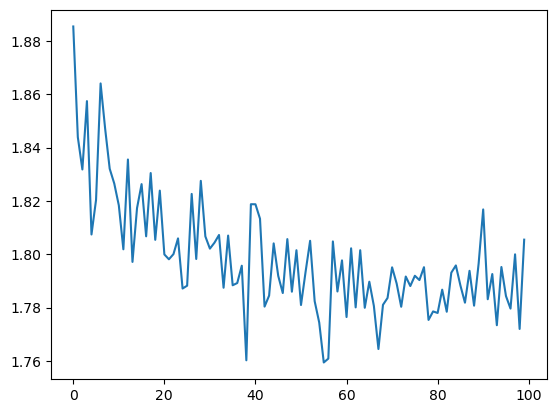

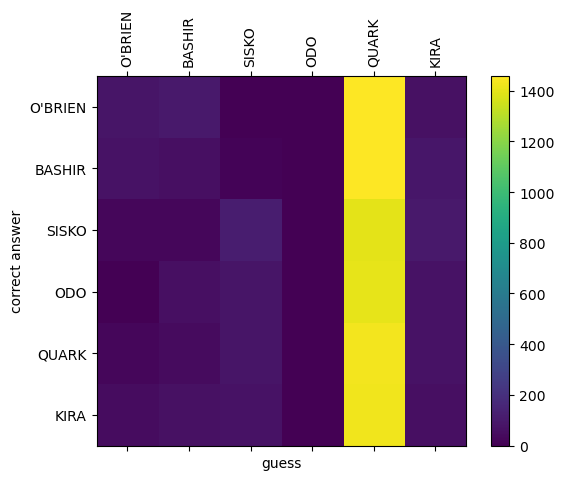


validating with more fewer categories and narrower range of tokens
We expect, if random guesses, n_correct = 83.333 +/- 8.333
500 5% (0m 1s) 90 You don't sound too sure. / O'BRIEN N (KIRA)
1000 10% (0m 2s) 93 Oh... that's good. / KIRA N (O'BRIEN)
1500 15% (0m 4s) 102 Looks just like her... / O'BRIEN Y
2000 20% (0m 5s) 85 There's no profit in kindness. / O'BRIEN N (ODO)
2500 25% (0m 7s) 95 Maraltian Seev-ale; from Quark's private stock. / QUARK N (ODO)
3000 30% (0m 9s) 90 How was the prayer service? / BASHIR N (ODO)
3500 35% (0m 10s) 87 Captain Cusak can you hear me! / QUARK N (BASHIR)
4000 40% (0m 12s) 74 Hot coffee black, double sweet. / SISKO N (O'BRIEN)
4500 45% (0m 13s) 100 That name mean something to you? / KIRA N (SISKO)
5000 50% (0m 15s) 97 She didn't want anything. / BASHIR N (ODO)
5500 55% (0m 16s) 101 You were working for the Cardassians. / O'BRIEN N (KIRA)
6000 60% (0m 18s) 85 Okay. Then what's... / BASHIR Y
6500 65% (0m 19s) 88 We only have six photons, Major... / O'BRIEN 

/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + char_categories, rotation=90)
/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/3653870477.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + char_categories)


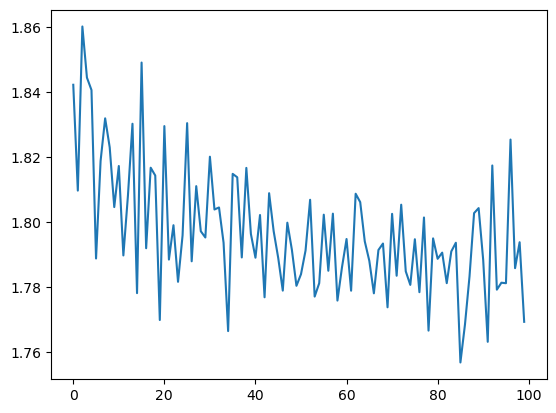

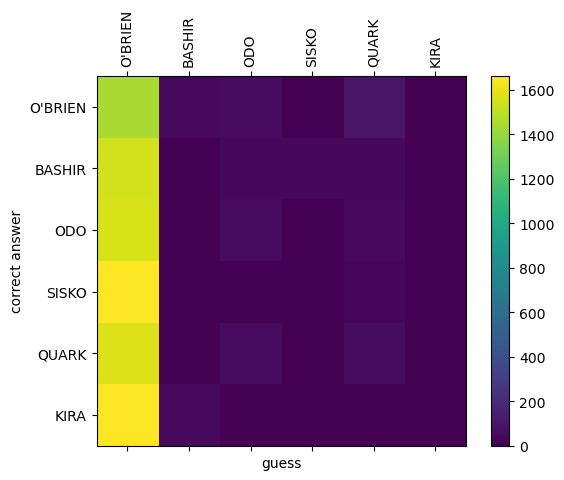

In [54]:
# Hyperparameter tuning:

# Here are all the hyperparameters (min/max_tokens isn't really a part of the model, but a part of the problem to be solved)
min_tokens = 3
max_tokens = 8

# this choice is dependent on the output = self.softmax(output) step... CE is often better, depending on situation
criterion = nn.NLLLoss()

learning_rate = 0.005

n_hidden = 128
embedding_dim = n_hidden


# now do the testing
print('')
print('===============================')
print('validating with baseline')
lang, train_df, valid_df, test_df, char_categories = prep_datasets(dialogue_df, min_tokens, max_tokens)
n_categories = len(char_categories)
rnn = RNN(lang.n_words, n_hidden, n_categories, embedding_dim)
rnn, loss_plot = train_model(rnn, train_df, 10000, criterion, learning_rate, verbose =True)
n_trials = valid_df.shape[0]*2
confusion, n_correct, avg_loss = evaluate(valid_df, n_trials)

p=1./len(char_categories)
print(f'After validation, we expect, if random guesses, n_correct = {p*n_trials:.3f} +/- {math.sqrt(n_trials*p*(1-p)):.3f}')
print(f'We got this many correct: {n_correct}/{n_trials} = {n_correct/n_trials*100.}%')
print(f'with an average loss of: {avg_loss}')
plt.figure()
plt.plot(loss_plot)
plot_confusion(confusion)


# again with few neurons
print('')
print('===============================')
print('validating with few neurons')
n_hidden = 64
embedding_dim = n_hidden
rnn = RNN(lang.n_words, n_hidden, n_categories, embedding_dim)
rnn, loss_plot = train_model(rnn, train_df, 10000, criterion, learning_rate, verbose =True)
n_trials = valid_df.shape[0]*2
confusion, n_correct, avg_loss = evaluate(valid_df, n_trials)

p=1./len(char_categories)
print(f'After validation, we expect, if random guesses, n_correct = {p*n_trials:.3f} +/- {math.sqrt(n_trials*p*(1-p)):.3f}')
print(f'We got this many correct: {n_correct}/{n_trials} = {n_correct/n_trials*100.}%')
print(f'with an average loss of: {avg_loss}')
plt.figure()
plt.plot(loss_plot)
plot_confusion(confusion)
n_hidden = 128
embedding_dim = n_hidden

print('')
print('===============================')
print('validating with faster learning')
learning_rate = 0.01
rnn = RNN(lang.n_words, n_hidden, n_categories, embedding_dim)
rnn, loss_plot = train_model(rnn, train_df, 10000, criterion, learning_rate, verbose =True)
n_trials = valid_df.shape[0]*2
confusion, n_correct, avg_loss = evaluate(valid_df, n_trials)

p=1./len(char_categories)
print(f'After validation, we expect, if random guesses, n_correct = {p*n_trials:.3f} +/- {math.sqrt(n_trials*p*(1-p)):.3f}')
print(f'We got this many correct: {n_correct}/{n_trials} = {n_correct/n_trials*100.}%')
print(f'with an average loss of: {avg_loss}')
plt.figure()
plt.plot(loss_plot)
plot_confusion(confusion)
learning_rate = 0.005

print('')
print('===============================')
print('validating with different loss fnc')
criterion = nn.CrossEntropyLoss()

rnn = RNN(lang.n_words, n_hidden, n_categories, embedding_dim)
rnn, loss_plot = train_model(rnn, train_df, 10000, criterion, learning_rate, verbose =True)
n_trials = valid_df.shape[0]*2
confusion, n_correct, avg_loss = evaluate(valid_df, n_trials)

p=1./len(char_categories)
print(f'After validation, we expect, if random guesses, n_correct = {p*n_trials:.3f} +/- {math.sqrt(n_trials*p*(1-p)):.3f}')
print(f'We got this many correct: {n_correct}/{n_trials} = {n_correct/n_trials*100.}%')
print(f'with an average loss of: {avg_loss}')
plt.figure()
plt.plot(loss_plot)
plot_confusion(confusion)
criterion = nn.NLLLoss()

print('')
print('===============================')
print('validating with more varied sentences')
min_tokens = 0
max_tokens = 100
lang, train_df, valid_df, test_df, char_categories = prep_datasets(dialogue_df, min_tokens, max_tokens)
n_categories = len(char_categories)
learning_rate = 0.005
rnn = RNN(lang.n_words, n_hidden, n_categories, embedding_dim)
rnn, loss_plot = train_model(rnn, train_df, 10000, criterion, learning_rate, verbose =True)
n_trials = valid_df.shape[0]*2
confusion, n_correct, avg_loss = evaluate(valid_df, n_trials)

p=1./len(char_categories)
print(f'After validation, we expect, if random guesses, n_correct = {p*n_trials:.3f} +/- {math.sqrt(n_trials*p*(1-p)):.3f}')
print(f'We got this many correct: {n_correct}/{n_trials} = {n_correct/n_trials*100.}%')
print(f'with an average loss of: {avg_loss}')
plt.figure()
plt.plot(loss_plot)
plot_confusion(confusion)
min_tokens = 3
max_tokens = 8

print('')
print('===============================')
print('validating with fewer categories')

lang, train_df, valid_df, test_df, char_categories = prep_datasets(dialogue_df, min_tokens, max_tokens, min_char_lines=5000)
n_categories = len(char_categories)
learning_rate = 0.005
rnn = RNN(lang.n_words, n_hidden, n_categories, embedding_dim)
rnn, loss_plot = train_model(rnn, train_df, 10000, criterion, learning_rate, verbose =True)
n_trials = valid_df.shape[0]*2
confusion, n_correct, avg_loss = evaluate(valid_df, n_trials)

p=1./len(char_categories)
print(f'After validation, we expect, if random guesses, n_correct = {p*n_trials:.3f} +/- {math.sqrt(n_trials*p*(1-p)):.3f}')
print(f'We got this many correct: {n_correct}/{n_trials} = {n_correct/n_trials*100.}%')
print(f'with an average loss of: {avg_loss}')
plt.figure()
plt.plot(loss_plot)
plot_confusion(confusion)

print('')
print('===============================')
print('validating with more fewer categories and narrower range of tokens')
min_tokens = 5
max_tokens = 7

lang, train_df, valid_df, test_df, char_categories = prep_datasets(dialogue_df, min_tokens, max_tokens, min_char_lines=5000)
n_categories = len(char_categories)
learning_rate = 0.005
rnn = RNN(lang.n_words, n_hidden, n_categories, embedding_dim)
rnn, loss_plot = train_model(rnn, train_df, 10000, criterion, learning_rate, verbose =True)
n_trials = valid_df.shape[0]*2
confusion, n_correct, avg_loss = evaluate(valid_df, n_trials)

p=1./len(char_categories)
print(f'After validation, we expect, if random guesses, n_correct = {p*n_trials:.3f} +/- {math.sqrt(n_trials*p*(1-p)):.3f}')
print(f'We got this many correct: {n_correct}/{n_trials} = {n_correct/n_trials*100.}%')
print(f'with an average loss of: {avg_loss}')
plt.figure()
plt.plot(loss_plot)
plot_confusion(confusion)
min_tokens = 3
max_tokens = 8

In [55]:
# after validating, these seem to be the best hyperparameters:

print('===============================')
print('final training')

if not dialogue_in_sentences:
    min_tokens = 3
    max_tokens = 8
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.005 
    n_hidden = 128
    embedding_dim = n_hidden
else:
    n_hidden = 64
    embedding_dim = n_hidden
    learning_rate = 0.01
    min_tokens = 3
    max_tokens = 8
    criterion = nn.NLLLoss()

lang, train_df, valid_df, test_df, char_categories = prep_datasets(dialogue_df, min_tokens, max_tokens, min_char_lines=1000)
n_categories = len(char_categories)
rnn = RNN(lang.n_words, n_hidden, n_categories, embedding_dim)
rnn, loss_plot = train_model(rnn, pd.concat([train_df, valid_df],ignore_index=True), 200000, criterion, learning_rate, verbose =True)
n_trials = test_df.shape[0]*2
confusion, n_correct, avg_loss = evaluate(test_df, n_trials)

p=1./n_categories
print(f'After testing, we expect, if random guesses, n_correct = {p*n_trials:.3f} +/- {math.sqrt(n_trials*p*(1-p)):.3f}')
print(f'We got this many correct: {n_correct}/{n_trials} = {n_correct/n_trials*100.}%')
print(f'with an average loss of: {avg_loss}')
plt.figure()
plt.plot(loss_plot)
plot_confusion(confusion)


final training
We expect, if random guesses, n_correct = 714.286 +/- 25.754
10000 5% (0m 38s) 889 Are you listening to me? / JAKE N (EZRI)
20000 10% (1m 18s) 1090 They're hailing us. / EZRI N (DAX)
30000 15% (1m 59s) 1236 How large of a dosage is required? / ROM N (ODO)
40000 20% (2m 39s) 1314 I don't know. / EZRI N (GARAK)
50000 25% (3m 19s) 1488 See for yourself. / KIRA N (NOG)
60000 30% (4m 0s) 1502 Aye, sir... / NOG N (BASHIR)
70000 35% (4m 40s) 1478 Boys, can you wait outside? / DAX Y
80000 40% (5m 20s) 1536 They need to be cleaned... / DUKAT N (O'BRIEN)
90000 45% (5m 59s) 1583 Computer, lights. Bridge to Engine Room. / WORF Y
100000 50% (6m 37s) 1560 Then why'd you order it? / GARAK N (JAKE)
110000 55% (7m 15s) 1592 You may go. / WORF Y
120000 60% (7m 53s) 1577 Not because of me. / GARAK N (DAX)
130000 65% (8m 31s) 1714 And what business might that be? / GARAK Y
140000 70% (9m 9s) 1729 Many times. / WORF Y
150000 75% (9m 47s) 1748 It's... a farming community. / GARAK N (KIRA)
160

NameError: name 'all_losses' is not defined

<Figure size 640x480 with 0 Axes>

/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/2643754301.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + char_categories, rotation=90)
/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_50178/2643754301.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + char_categories)


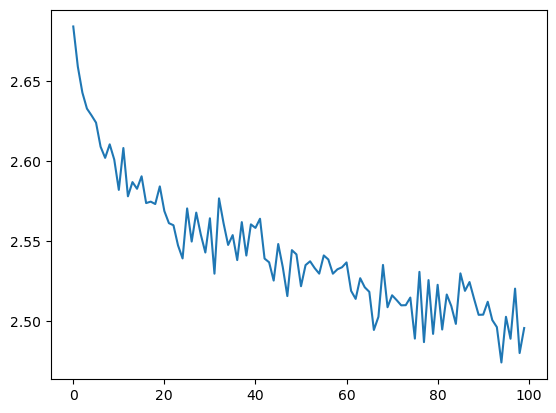

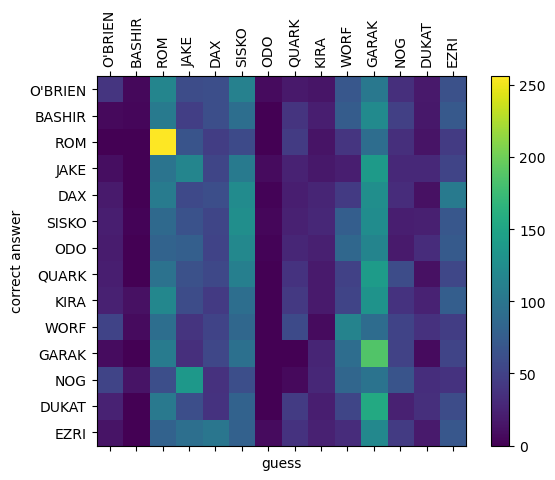

saving plot to: trained_confusion.png


<Figure size 640x480 with 0 Axes>

In [61]:
plt.figure()
plt.plot(loss_plot)
plt.savefig('loss_plot.png', bbox_inches='tight')
fig, ax = plot_confusion(confusion, save_name = 'trained_confusion.png')
#plt.show()
#fig.savefig('trained_confusion.png', bbox_inches='tight')

In [55]:
from IPython.display import clear_output

def evaluate_user(test_df):
    # Keep track of guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    in_str = ''
    char_dict = {k: v for k, v in enumerate(char_categories)}

    print('Try to guess the character who spoke the line.')
    print('Your options are:')
    display(char_dict)
    print('type "h" to see help, and "stop" to stop')

    line = ''
    guess = ''
    category = ''
    n_trials = 0
    
    # Go through a bunch of examples and record which are correctly guessed
    while in_str != 'stop':
        clear_output(wait=True)
        if line != '':
            print(line)
            print(f'Your guess = {guess}, correct answer = {category}')
        
        category, line, category_tensor, line_tensor = randomTrainingExample(test_df)
        
        print(f'[{n_trials}] Your options are:')
        display(char_dict)
        
        in_str = input(f'{line}')
        
        if in_str == 'stop':
            clear_output(wait=True)
            print(line)
            print(f'Your guess = {guess}, correct answer = {category}')
            break
        elif in_str == 'h':
            print('Try to guess the character who spoke the line.')
            print('type "h" to see help, and "stop" to stop')
            continue
        elif int(in_str) not in char_dict.keys():
            print('Please type a number corresponding to the character')
            continue

        guess_i = int(in_str)
        guess = char_dict[guess_i]#char_categories[category_i]
        
        category_i = char_categories.index(category)
        confusion[category_i][guess_i] += 1
        n_trials += 1


    n_correct = 0
    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        n_correct += int(confusion[i][i])
        #confusion_trained[i] = confusion_trained[i] / confusion_trained[i].sum()
    n_trials = confusion.sum(dtype = int).sum(dtype = int).item()
    
    print(f'you got {n_correct}/{n_trials} = {n_correct/n_trials*100.}%')
    plot_confusion(confusion)
    return

not on ferenginar.
Your guess = GARAK, correct answer = ROM
you got 32/150 = 21.333333333333336%


/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_29310/3653870477.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + char_categories, rotation=90)
/var/folders/rs/1xhk0knx1w3d7rj_csl4n2wc0000gn/T/ipykernel_29310/3653870477.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + char_categories)


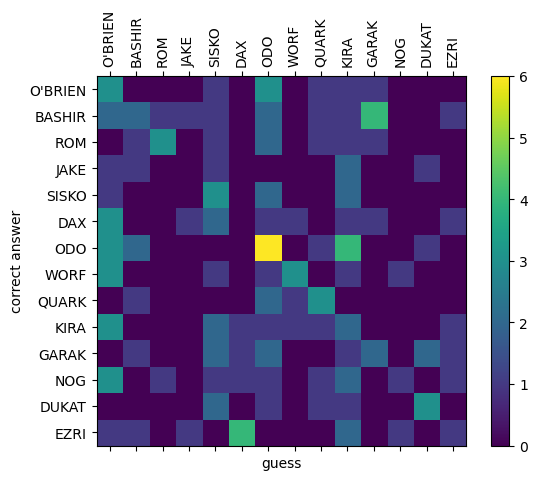

In [57]:
evaluate_user(test_df, save_name = '')

In [129]:
torch.save(rnn.state_dict(), "rnn.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
